In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)
af

# torch dataset
class TCRDataset(Dataset):
    '''
    Use each two rows of data as a sample (one for alpha chain, one for beta chain), each sample has the common cellname
    Different from the chain, the HLA class is the same for each sample
    The aaSeqCDR1, aaSeqCDR2, aaSeqCDR3 are the CDR1, CDR2, CDR3 of the alpha chain and beta chain, respectively.
    '''
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        df["Neo"] = df["NeoAA"].str.slice(0,3) + "_" + df["NeoAA"].str.slice(-4,-1)
        df.drop(columns=["NeoAA"], inplace=True)
        for chain in ["AseqCDR", "BseqCDR"]:
            df[chain+"_1"] = df[chain].str.split("_").str[0]
            df[chain+"_2"] = df[chain].str.split("_").str[1]
            df[chain+"_3"] = df[chain].str.split("_").str[2]
            df.drop(columns=[chain], inplace=True)
        seq_list = ["AseqCDR_1", "AseqCDR_2", "AseqCDR_3", "BseqCDR_1", "BseqCDR_2", "BseqCDR_3"]
        # Find the longest sequence in each CDR
        len_map = df[seq_list].applymap(len).max()
        for column in seq_list:
            df[column] = df[column].str.ljust(len_map[column], "*")
        dataset = df[['AseqCDR_1', 'AseqCDR_2', 'AseqCDR_3', 'BseqCDR_1', 'BseqCDR_2', 'BseqCDR_3', 'Neo', 'HLA']]
        for seq in seq_list:
            encode_seq_result = list()
            for i in dataset[seq]:
                encode_seq_result.append(encode_seqCDR(i))
            col_name = seq + "_encode"
            dataset[col_name] = encode_seq_result
        X_feature = np.zeros((dataset.shape[0], 0))
        for seq in seq_list:
            col_name = seq + "_encode"
            col_feature = np.zeros((0, len_map[seq]*5))
            for i in range(dataset.shape[0]):
                col_feature = np.vstack((col_feature, dataset.loc[i, col_name].reshape(1,-1)))
            X_feature = np.hstack((X_feature, col_feature))

        # one-hot encode Neo
        X_neo = dataset["Neo"].values.reshape(-1,1)
        onehotEncoder = OneHotEncoder()
        X_neo = onehotEncoder.fit_transform(X_neo).toarray()

        # one-hot encode HLA
        labelencoder = LabelEncoder()
        y = labelencoder.fit_transform(dataset["HLA"].values.reshape(-1,1))

        # get the final feature matrix
        self.features = np.hstack((X_neo, X_feature))
        self.labels = y

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):        
        return self.features[idx], self.labels[idx]

In [4]:
file_path = '/home/wuxinchao/data/project/data/seqData/230215.csv'
TCRData = TCRDataset(file_path)

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
class pMHC_TCR_model(nn.Module):
    def __init__(self, input_size, batch_size=32 ,hidden_size=5, num_layers=2, device="cpu", use_whole_data=False):
        super(pMHC_TCR_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
        if use_whole_data:
            self.batch_size = 0
        else:
            self.batch_size = batch_size

        # classification of the output of the last time step
        self.label = nn.Linear(hidden_size, 1)

    def forward(self, input):
        # input: L, input_size
        if self.batch_size==1:
            x = input.float()
            h_0 = Variable(torch.zeros(self.num_layers, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers, self.hidden_size).to(self.device))
            out, (hn, cn) = self.lstm(x, (h_0, c_0))
            pred = self.label(out[-1, :])
        elif self.batch_size==0:
            # The whole data is used as a batch, input: data_size, input_size
            x = input.float()
            h_0 = Variable(torch.zeros(self.num_layers, self.hidden_size).to(self.device)) # D * num_layers, output_size
            c_0 = Variable(torch.zeros(self.num_layers, self.hidden_size).to(self.device)) # D * num_layers, hidden_size
            out, (hn, cn) = self.lstm(x, (h_0, c_0)) # out: L, D * output_size
            # print(out.shape)
            pred = self.label(out) # pred: len_of_dataset * 1
            # print(pred.shape)
        else:
            x = input.view(-1, self.batch_size, self.input_size).float()
            # print(x.shape)
            # h_0: (num_layers * num_directions, batch, hidden_size)
            h_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            out, (hn, cn) = self.lstm(x, (h_0, c_0))
            pred = self.label(out[-1, :, :])
        return pred

In [71]:
def train(fold, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float()
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.view(-1)
        # print(output.shape, target.shape)
        loss = nn.CrossEntropyLoss()(output, target)
        # loss = F.nll_loss(output, target)
        # loss = F.cross_entropy(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                fold, epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss / len(data)
            
def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).float()
            # data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.view(-1)
            # using loss function to calculate the loss
            test_loss += nn.CrossEntropyLoss()(output, target).item()  # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # print(output, target)
            # pred = output.argmax(dim=1, keepdim=True)
            pred = output.sigmoid().round()  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set for fold {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\
    '.format(fold, test_loss, correct, len(test_loader.dataset),  100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [25]:
# not used
epoch_train_loss = []
epoch_test_loss = []
epoch_train_acc = []
epoch_test_acc = []

x_epoch = []

def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, epoch_train_loss, 'bo-', label="train")
    ax0.plot(x_epoch, epoch_test_loss, 'ro-', label="val")
    ax1.plot(x_epoch, epoch_train_acc, 'bo-', label="train")
    ax1.plot(x_epoch, epoch_test_acc, 'ro-', label="val")
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join("./lossGraphs", "train.jpg"))

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")

torch.Size([755, 1])

Using cuda:0 for training the network
-------------------Fold 0-------------------
Train Fold/Epoch: 0/1 [0/886 (0%)]	Loss: 4226.730469
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/2 [0/886 (0%)]	Loss: 4226.901367
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/3 [0/886 (0%)]	Loss: 4226.512695
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/4 [0/886 (0%)]	Loss: 4226.165039
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/5 [0/886 (0%)]	Loss: 4226.456055
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/6 [0/886 (0%)]	Loss: 4226.492676
Test set for fold 0: Average loss: 0.9475, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/7 [0/886 (0%)]	Loss: 4226.422363
Test set for fold 0: Average loss: 0.9474, Accuracy: 16/886 (2%)    
Train Fold/Epoch: 0/8 [0/886 (0%)]	Loss: 4226.149414
Test set f

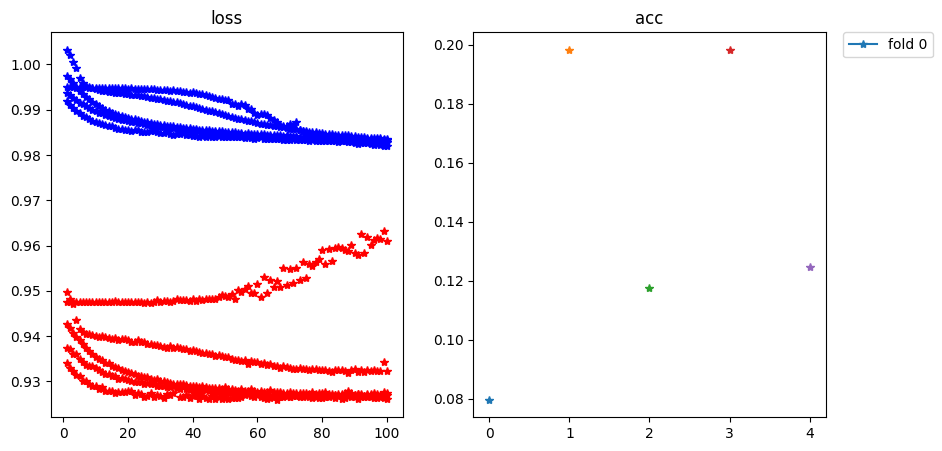

In [79]:
batch_size = 1
use_whole_data = True
seq_length = 2
folds = 5
repeats = 12
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} for training the network")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = pMHC_TCR_model(input_size=356, batch_size=batch_size, device=device, use_whole_data=use_whole_data).to(device)

# kf = RepeatedKFold(n_splits=10, n_repeats=12, random_state=1234)
# kf = KFold(n_splits=10, random_state=1234, shuffle=True)
kf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)
weights = torch.FloatTensor([1, 9])
optimizer = optim.Adadelta(model.parameters())

loss_history = []
acc_history = []

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("loss")
ax[1].set_title("acc")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.features, TCRData.labels)):
    print(f"-------------------Fold {fold}-------------------")
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        # train_subsampler = WeightedRandomSampler(weights, len(train_idx), replacement=True)
        # test_subsampler = WeightedRandomSampler(weights, len(test_idx), replacement=True)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=batch_size, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=batch_size, sampler=test_subsampler)
        
    model.apply(reset_weights)

    accuracy_history = []

    for epoch in range(1, epochs + 1):
        train_losses = train(fold, model, device, train_loader, optimizer, epoch)
        test_losses, correctness = test(fold, model, device, test_loader)
        accuracy_history.append(correctness)
        ax[0].plot(epoch, train_losses, 'b*-')
        ax[0].plot(epoch, test_losses, 'r*-')
        # plt.plot(epoch, train_losses, 'b*-')
        # plt.plot(epoch, test_losses, 'r*-')
        if fold==1 and epoch == 1:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        # plt.savefig(os.path.join("./lossGraphs", "train.jpg"))
    ax[1].plot(fold, np.mean(accuracy_history), '*-', label=f"fold {fold}")

In [67]:
# F.nll_loss(torch.tensor([-0.1]), torch.tensor([1]))
# torch.tensor([-22]).sigmoid()
# nn.CrossEntropyLoss()(torch.tensor([-1.]), torch.tensor([1.]))
True & False

False

In [ ]:
# plot the loss curve

# plot the accuracy curve

# plot the ROC curve

# plot the PR curve

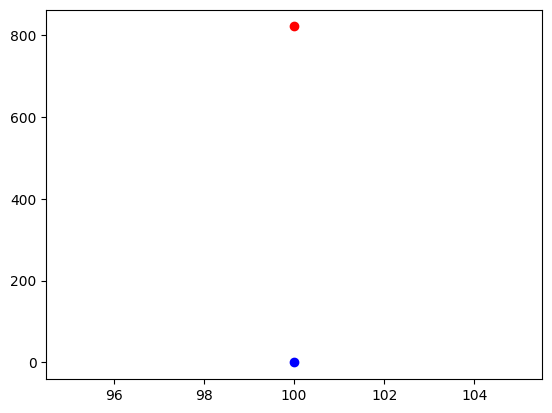

In [57]:
plt.plot(epoch, train_losses/len(TCRData), 'bo-', label="train")
plt.plot(epoch, test_losses, 'ro-', label="val")

In [2]:
file_path = '/home/wuxinchao/data/project/data/seqData/230215.csv'
df = pd.read_csv(file_path)

In [3]:
# The data in df are the positive sample pair that could be used to define the affinity value as 1
df

,cellname,NeoAA,HLA,AseqCDR,BseqCDR
0,V350085868_L01_502,VLLSHLSYL,HLA-A*02:01,TSESDYY_QEAYKQQN_CAYRAYMEYGNKLVF,SGHTA_FQGNSA_CASSLGVYEQYF
1,V350085868_L01_505,VLLSHLSYL,HLA-A*02:01,NIATNDY_GYKTK_CLVGTNSNSGYALNF,LGHNT_FRNRAP_CASGSPDRFEQYF
2,V350085868_L01_506,VLLSHLSYL,HLA-A*02:01,ATGYPS_ATKADDK_CALTVSYGGSQGNLIF,KGHSH_LQKENI_CASSPFSIGQGLTNNEKLFF
3,V350085868_L01_507,SLMEQIPHL,HLA-A*02:01,TSGFNG_NVLDGL_CAVKMNTGFQKLVF,DFQATT_SNEGSKA_CSAKLRGSNQPQHF
4,V350085868_L01_509,VLLSHLSYL,HLA-A*02:01,MNHNS_SASEGT_CASTLRAGWDEQFF,MNHEY_SMNVEV_CASSLSPGGRSEAFF
...,...,...,...,...,...
881,V350110758_L02_515,VVVGAGDVGK,HLA-A*11:01,NSMFDY_ISSIKDK_CAAAYYTGANSKLTF,SGHAT_FQNNGV_CASSSPPGVGNEQFF
882,V350110758_L02_522,VVVGAGDVGK,HLA-A*11:01,NSMFDY_ISSIKDK_CAASGTGTASKLTF,SGHNS_FNNNVP_CASETSNNEQFF
883,V350110758_L02_523,VVVGAGDVGK,HLA-A*11:01,SSNFYA_MTLNGDE_CAFYGSARQLTF,PRHDT_FYEKMQ_CASSPPTTAANYGYTF
884,V350110758_L02_531,VVVGAGDVGK,HLA-A*11:01,DSAIYN_IQSSQRE_CAVRGNNNARLMF,GTSNPN_SVGIG_CAWSPGRSPLHF


In [52]:
file_path = '/home/wuxinchao/data/project/data/seqData/TCR-pMHC_Info_20230220.xlsx'
df = pd.read_excel(file_path)

In [73]:
# df.columns # 'Class', 'cellname', 'NeoGeneID', 'NeoAA', 'NeoGeneNo', 'chain',
    #    'TCR_ID', 'V_segment', 'J_segment', 'TPM', 'libraryID', 'TCRnt', 'HLA',
    #    'nSeqHLA', 'aaSeqHLA', 'nSeqFR1', 'nSeqCDR1', 'nSeqFR2', 'nSeqCDR2',
    #    'nSeqFR3', 'nSeqCDR3', 'nSeqFR4', 'aaSeqFR1', 'aaSeqCDR1', 'aaSeqFR2',
    #    'aaSeqCDR2', 'aaSeqFR3', 'aaSeqCDR3', 'aaSeqFR4'
# df["NeoGeneNo"].unique()
# len(df["aaSeqHLA"].unique()) # 23
# len(df["aaSeqHLA"].unique().max()) # 362
# df["aaSeqHLA"].describe()
df

,Class,cellname,NeoGeneID,NeoAA,NeoGeneNo,chain,TCR_ID,V_segment,J_segment,TPM,...,nSeqFR3,nSeqCDR3,nSeqFR4,aaSeqFR1,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,aaSeqCDR3,aaSeqFR4
0,positive,V350085868_L01_502,CRC06C1,VLLSHLSYL,CRC06C1,TRA,TRAV38-2_DV8_ATAGGGCTTACATGGAA_TRAJ47,TRAV38-2_DV8*01,TRAJ47*01,1156.94,...,GCAACAGAGAATCGTTTCTCTGTGAACTTCCAGAAAGCAGCCAAAT...,TGTGCTTATAGGGCTTACATGGAATATGGAAACAAACTGGTCTTT,GGCGCAGGAACCATTCTGAGAGTCAAGTCCT,AQTVTQSQPEMSVQEAETVTLSCTYD,TSESDYY,LFWYKQPPSRQMILVIR,QEAYKQQN,ATENRFSVNFQKAAKSFSLKISDSQLGDAAMYF,CAYRAYMEYGNKLVF,GAGTILRVKS_
1,positive,V350085868_L01_502,CRC06C1,VLLSHLSYL,CRC06C1,TRB,TRBV7-2_CTTAGGCGTTTACGA_TRBJ2-7,TRBV7-2*02,TRBJ2-7*01,456.834,...,CCAGACAAATCAGGGCTGCCCAGTGATCGCTTCTCTGCAGAGAGGA...,TGTGCCAGCAGCTTAGGCGTTTACGAGCAGTACTTC,GGGCCGGGCACCAGGCTCACGGTCACAG,GAGVSQSPSNKVTEKGKDVELRCDPI,SGHTA,LYWYRQRLGQGLEFLIY,FQGNSA,PDKSGLPSDRFSAERTGESVSTLTIQRTQQEDSAVYL,CASSLGVYEQYF,GPGTRLTVT_
2,positive,V350085868_L01_503,CRC06C1,VLLSHLSYL,CRC06C1,TRA,TRAV13-1_GCAGCCATCATGGAA_TRAJ47,TRAV13-1*01,TRAJ47*01,2585.34,...,AAGAAAGACCAACGAATTGCTGTTACATTGAACAAGACAGCCAAAC...,TGTGCAGCCATCATGGAATATGGAAACAAACTGGTCTTT,GGCGCAGGAACCATTCTGAGAGTCAAGTCCT,GENVEQHPSTLSVQEGDSAVIKCTYS,DSASNY,FPWYKQELGKGPQLIID,IRSNVGE,KKDQRIAVTLNKTAKHFSLHITETQPEDSAVYF,CAAIMEYGNKLVF,GAGTILRVKS_
3,positive,V350085868_L01_503,CRC06C1,VLLSHLSYL,CRC06C1,TRB,TRBV5-6_CAGCTGGACGGCGAACA_TRBJ1-1,TRBV5-6*01,TRBJ1-1*01,269.324,...,AGACAGAGAGGCAACTTCCCTGATCGATTCTCAGGTCACCAGTTCC...,TGTGCCAGCAGCTGGACGGCGAACACTGAAGCTTTCTTT,GGACAAGGCACCAGACTCACAGTTGTAG,DAGVTQSPTHLIKTRGQQVTLRCSPK,SGHDT,VSWYQQALGQGPQFIFQ,YYEEEE,RQRGNFPDRFSGHQFPNYSSELNVNALLLGDSALYL,CASSWTANTEAFF,GQGTRLTVV_
4,positive,V350085868_L01_504,CRC06C1,VLLSHLSYL,CRC06C1,TRA,TRAV12-3_CAATGGGAACAAC_TRAJ24,TRAV12-3*01,"TRAJ24*01,TRAJ24*02",1596.76,...,AAAGAAGATGGAAGGTTTACAGCACAGGTCGATAAATCCAGCAAGT...,TGTGCAATGGGAACAACTGACAGCTGGGGGAAATTCGAGTTT,GGAGCAGGGACCCAGGTTGTGGTCACCCCAG,QKEVEQDPGPLSVPEGAIVSLNCTYS,NSAFQY,FMWYRQYSRKGPELLMY,TYSSGN,KEDGRFTAQVDKSSKYISLFIRDSQPSDSATYL,CAMGTTDSWGKFEF,GAGTQVVVTP_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,negative,V350110758_L02_592,-,-,-,TRB,TRBV21-1_AGCAAGACCCTAAGATTCCTACCGATCGACCGTACGA...,TRBV21-1*01,TRBJ2-1*01,553.09,...,ATTCAGAAAGCAGAAATAATCAATGAGCGATTTTTAGCCCAATGCT...,TGTGCCAGCAGCAAGACCCTAAGATTCCTACCGATCGACCGTACGA...,GGGCCAGGGACACGGCTCACCGTGCTAG,DTKVTQRPRLLVKASEQKAKMDCVPI,KAHSY,VYWYRKKLEEELKFLVY,FQNEEL,IQKAEIINERFLAQCSKNSSCTLEIQSTESGDTALYF,CASSKTLRF_TDRPYEQFF,GPGTRLTVL_
2810,negative,V350110758_L02_595,-,-,-,TRA,TRAV27_CAAGGGATTT_TRAJ23,TRAV27*01,TRAJ23*01,1672.05,...,AAGAAGCTGAAGAGACTAACCTTTCAGTTTGGTGATGCAAGAAAGG...,TGTCAAGGGATTTATAACCAGGGAGGAAAGCTTATCTTC,GGACAGGGAACGGAGTTATCTGTGAAACCCA,TQLLEQSPQFLSIQEGENLTVYCNSS,SVFSS,LQWYRQEPGEGPVLLVT,VVTGGEV,KKLKRLTFQFGDARKDSSLHITAAQPGDTGLYL,CQGIYNQGGKLIF,GQGTELSVKP_
2811,negative,V350110758_L02_595,-,-,-,TRB,TRBV2_AGTGATGGGACAGGGGCGAATGA_TRBJ2-1,TRBV2*01,TRBJ2-1*01,238.21,...,TCAGAGAAGTCTGAAATATTCGATGATCAATTCTCAGTTGAAAGGC...,TGTGCCAGCAGTGATGGGACAGGGGCGAATGAGCAGTTCTTC,GGGCCAGGGACACGGCTCACCGTGCTAG,EPEVTQTPSHQVTQMGQEVILRCVPI,SNHLY,FYWYRQILGQKVEFLVS,FYNNEI,SEKSEIFDDQFSVERPDGSNFTLKIRSTKLEDSAMYF,CASSDGTGANEQFF,GPGTRLTVL_
2812,negative,V350110758_L02_596,-,-,-,TRA,TRAV13-2_GAATAGATTAAGAAAGATAG_TRAJ35,TRAV13-2*01,TRAJ35*01,3895.07,...,AGGCAAGGCCAAAGAGTCACCGTTTTATTGAATAAGACAGTGAAAC...,TGTGCAGAGAATAGATTAAGAAAGATAGGCTTTGGGAATGTGCTGC...,GGTCCGGCACTCAAGTGATTGTTTTACCAC,GESVGLHLPTLSVQEGDNSIINCAYS,NSASDY,FIWYKQESGKGPQFIID,IRSNMDK,RQGQRVTVLLNKTVKHLSLQIAATQPGDSAVYF,CAENRLRKI_ALGMCCIA,GPALK*LFYH


In [7]:
pos_data = df.loc[df['Class'] == 'positive'] # 2296 samples of positive data
neg_data = df.loc[df['Class'] == 'negative'] # 518 samples of negative data

In [12]:
df = df[["Class", "cellname", "NeoAA", "chain", "HLA", "aaSeqCDR1", "aaSeqCDR2", "aaSeqCDR3"]]
pos_data = df.loc[df['Class'] == 'positive'] # 2296 samples of positive data
neg_data = df.loc[df['Class'] == 'negative'] # 518 samples of negative data

In [25]:
df.to_csv("/home/wuxinchao/data/project/data/seqData/230220.csv")

In [16]:
df = df.set_index(['cellname', "chain"])
# extract the NeoAA, HLA, and aaSeqCDR columns
df = df[["NeoAA", "HLA", "aaSeqCDR1", "aaSeqCDR2", "aaSeqCDR3", "Class"]]
df["aaSeqCDR"] = df[df.columns[2:-1]].apply(
    # lambda x: x[0] + 'X' * (7 - len(x[0])) + x[1] + x[2],
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)

In [19]:
idx = pd.IndexSlice

df_a = df.loc[idx[:,"TRA"],]
df_a["AseqCDR"] = df_a["aaSeqCDR"]
df_a.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
# drop the chain index
df_a.index = df_a.index.droplevel(1)
# print(df_a)
df_b = df.loc[idx[:,"TRB"],]
df_b["BseqCDR"] = df_b["aaSeqCDR"]
df_b.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
# drop the chain index
df_b.index = df_b.index.droplevel(1)
# print(df_b)

# merge the TRA and TRB dataframes by cellname, HLAs, and NeoAA
df_ab = pd.merge(df_a, df_b, on=["cellname", "HLA", "NeoAA", "Class"])
df_ab

/tmp/ipykernel_1919009/2937025875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a["AseqCDR"] = df_a["aaSeqCDR"]
/tmp/ipykernel_1919009/2937025875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
/tmp/ipykernel_1919009/2937025875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,NeoAA,HLA,Class,AseqCDR,BseqCDR
cellname,,,,,
V350085868_L01_502,VLLSHLSYL,HLA-A*02:01,positive,TSESDYY_QEAYKQQN_CAYRAYMEYGNKLVF,SGHTA_FQGNSA_CASSLGVYEQYF
V350085868_L01_503,VLLSHLSYL,HLA-A*02:01,positive,DSASNY_IRSNVGE_CAAIMEYGNKLVF,SGHDT_YYEEEE_CASSWTANTEAFF
V350085868_L01_504,VLLSHLSYL,HLA-A*02:01,positive,NSAFQY_TYSSGN_CAMGTTDSWGKFEF,DFQATT_SNEGSKA_CSVRNGYEQYF
V350085868_L01_505,VLLSHLSYL,HLA-A*02:01,positive,NIATNDY_GYKTK_CLVGTNSNSGYALNF,LGHNT_FRNRAP_CASGSPDRFEQYF
V350085868_L01_506,VLLSHLSYL,HLA-A*02:01,positive,ATGYPS_ATKADDK_CALTVSYGGSQGNLIF,KGHSH_LQKENI_CASSPFSIGQGLTNNEKLFF
...,...,...,...,...,...
V350110758_L02_589,-,-,negative,DRGSQS_IYSNGD_CAVSRYSTLTF,DFQATT_SNEGSKA_CSASTVNTEAFF
V350110758_L02_591,-,-,negative,DSSSTY_IFSNMDM_CAESLTGGFKTIF,KAHSY_FQNEEL_CASSKTLRF_TDRPYEQFF
V350110758_L02_592,-,-,negative,DSVNN_IPSGT_CAVISNFGNEKLTF,KAHSY_FQNEEL_CASSKTLRF_TDRPYEQFF


In [28]:
import random

In [22]:
df["Neo"] = df["NeoAA"].str.slice(0,3) + "_" + df["NeoAA"].str.slice(-4,-1)
df.drop(columns=["NeoAA"], inplace=True)
for chain in ["AseqCDR", "BseqCDR"]:
    df[chain+"_1"] = df[chain].str.split("_").str[0]
    df[chain+"_2"] = df[chain].str.split("_").str[1]
    df[chain+"_3"] = df[chain].str.split("_").str[2]
    df.drop(columns=[chain], inplace=True)

,HLA,Class,Neo,AseqCDR_1,AseqCDR_2,AseqCDR_3,BseqCDR_1,BseqCDR_2,BseqCDR_3
cellname,,,,,,,,,
V350085868_L01_502,HLA-A*02:01,positive,VLL_LSY,TSESDYY,QEAYKQQN,CAYRAYMEYGNKLVF,SGHTA,FQGNSA,CASSLGVYEQYF
V350085868_L01_503,HLA-A*02:01,positive,VLL_LSY,DSASNY,IRSNVGE,CAAIMEYGNKLVF,SGHDT,YYEEEE,CASSWTANTEAFF
V350085868_L01_504,HLA-A*02:01,positive,VLL_LSY,NSAFQY,TYSSGN,CAMGTTDSWGKFEF,DFQATT,SNEGSKA,CSVRNGYEQYF
V350085868_L01_505,HLA-A*02:01,positive,VLL_LSY,NIATNDY,GYKTK,CLVGTNSNSGYALNF,LGHNT,FRNRAP,CASGSPDRFEQYF
V350085868_L01_506,HLA-A*02:01,positive,VLL_LSY,ATGYPS,ATKADDK,CALTVSYGGSQGNLIF,KGHSH,LQKENI,CASSPFSIGQGLTNNEKLFF
...,...,...,...,...,...,...,...,...,...
V350110758_L02_589,-,negative,-_,DRGSQS,IYSNGD,CAVSRYSTLTF,DFQATT,SNEGSKA,CSASTVNTEAFF
V350110758_L02_591,-,negative,-_,DSSSTY,IFSNMDM,CAESLTGGFKTIF,KAHSY,FQNEEL,CASSKTLRF
V350110758_L02_592,-,negative,-_,DSVNN,IPSGT,CAVISNFGNEKLTF,KAHSY,FQNEEL,CASSKTLRF


In [31]:
# Create some negative sample by randomly mutant the aa of CDR3 sequence
df_ng = df.copy()
df_ng["Class"] = "negative"
df_ng["AseqCDR_3"] = df_ng["AseqCDR_3"].apply(lambda x: random.choice(list(set(df["AseqCDR_3"]) - set(x))))
df_ng["BseqCDR_3"] = df_ng["BseqCDR_3"].apply(lambda x: random.choice(list(set(df["BseqCDR_3"]) - set(x))))

In [32]:
# set(df["AseqCDR_3"].unique()) 
df_ng

,HLA,Class,Neo,AseqCDR_1,AseqCDR_2,AseqCDR_3,BseqCDR_1,BseqCDR_2,BseqCDR_3
cellname,,,,,,,,,
V350085868_L01_502,HLA-A*02:01,negative,VLL_LSY,TSESDYY,QEAYKQQN,CAVRRGGADGLTF,SGHTA,FQGNSA,CASSGGPRQPQHF
V350085868_L01_503,HLA-A*02:01,negative,VLL_LSY,DSASNY,IRSNVGE,AVGETGANNLF,SGHDT,YYEEEE,CASNPPGGDTEAFF
V350085868_L01_504,HLA-A*02:01,negative,VLL_LSY,NSAFQY,TYSSGN,CIPLRRRF,DFQATT,SNEGSKA,CASSPLGSNQPQHF
V350085868_L01_505,HLA-A*02:01,negative,VLL_LSY,NIATNDY,GYKTK,CAVSSNQAGTALIF,LGHNT,FRNRAP,CASEDSSYNEQFF
V350085868_L01_506,HLA-A*02:01,negative,VLL_LSY,ATGYPS,ATKADDK,CVVSDRGDMRF,KGHSH,LQKENI,ASSSWDTGELF
...,...,...,...,...,...,...,...,...,...
V350110758_L02_589,-,negative,-_,DRGSQS,IYSNGD,CAMRESGAGSYQLTF,DFQATT,SNEGSKA,CASSYSRMNTEAFF
V350110758_L02_591,-,negative,-_,DSSSTY,IFSNMDM,CGTESSQGGSQGNLIF,KAHSY,FQNEEL,CASSLTLTSRYEQYF
V350110758_L02_592,-,negative,-_,DSVNN,IPSGT,CAVRDGGGFKTIF,KAHSY,FQNEEL,CASHIAGAYEQYF


In [34]:
df_pos = df[df["Class"] == "positive"]

In [35]:
df_pos 

,HLA,Class,Neo,AseqCDR_1,AseqCDR_2,AseqCDR_3,BseqCDR_1,BseqCDR_2,BseqCDR_3
cellname,,,,,,,,,
V350085868_L01_502,HLA-A*02:01,positive,VLL_LSY,TSESDYY,QEAYKQQN,CAYRAYMEYGNKLVF,SGHTA,FQGNSA,CASSLGVYEQYF
V350085868_L01_503,HLA-A*02:01,positive,VLL_LSY,DSASNY,IRSNVGE,CAAIMEYGNKLVF,SGHDT,YYEEEE,CASSWTANTEAFF
V350085868_L01_504,HLA-A*02:01,positive,VLL_LSY,NSAFQY,TYSSGN,CAMGTTDSWGKFEF,DFQATT,SNEGSKA,CSVRNGYEQYF
V350085868_L01_505,HLA-A*02:01,positive,VLL_LSY,NIATNDY,GYKTK,CLVGTNSNSGYALNF,LGHNT,FRNRAP,CASGSPDRFEQYF
V350085868_L01_506,HLA-A*02:01,positive,VLL_LSY,ATGYPS,ATKADDK,CALTVSYGGSQGNLIF,KGHSH,LQKENI,CASSPFSIGQGLTNNEKLFF
...,...,...,...,...,...,...,...,...,...
A6,HLA-A*02:01,positive,LLF_PVA,DRGSQS,IYSNGD,AVTTDSWGKLQ,MNHEY,SVGAGI,ASRPGLAGGRPEQY
α24ß17,HLA-A*02:01,positive,ELA_ILT,FLGSQS,TYREGD,AVNDGGRLT,GTSNPN,WGPFG,AWSETGLGMGGWQ
α24ß17,HLA-A*02:01,positive,ELA_ILT,FLGSQS,TYREGD,AVNDGGRLT,GTSNPN,WGPFG,AWSETGLGMGGWQ


In [50]:
# df[["HLA", "Neo"]].value_counts()
# df["Neo"].value_counts()
df_pos["HLA"].value_counts()

HLA-A*11:01                  988
HLA-A*02:01                  121
HLA-A*24:02                    6
HLA-B*35:01                    6
HLA-B*35:08                    5
HLA-DQA1*03:01/DQB1*03:02      3
HLA-DRB1*04:01                 3
HLA-B*44:05                    2
HLA-DQA1*05:01/DQB1*02:01      2
HLA-B*07:02                    2
HLA-DQA1*01:02/DQB1*05:02      2
HLA-DRA*01:01/DRB1*04:01       1
HLA-DQA1*05:01/DQB1*03:02      1
HLA-DQA1*02:01/DQB1*02:02      1
HLA-DPB1*02:01                 1
HLA-DQ1                        1
HLA-B*51:01                    1
HLA-DRB1*01:01                 1
HLA-DRA*01:01/DRB5*01:01       1
HLA-A*01:01                    1
HLA-A*02:01 T163A mutant       1
HLA-A*02:01 W167A mutant       1
HLA-A*02:01 K66A mutant        1
HLA-B*08:01                    1
HLA-DRA*01:01/DRB1*15:01       1
Name: HLA, dtype: int64

In [ ]:
import random
import tqdm
import logging

In [ ]:
# build NSP task dataset

def read_data(file_path = None):
    '''
    Read the data from the csv file, and each line is a sample.
    Column 1: the name of the sample
    Column 2: the sequence of the neo-antigen
    Column 3: the classification of HLA
    Column 4: the sequence of the TCR alpha chain (only CDR3)
    Column 5: the sequence of the TCR beta chain (only CDR3)
    After the processing, we would get a one-dimensional list
    '''
    df = pd.read_csv(file_path)
    datasets = []
    for sample in tqdm(df, desc='Reading data'):
        datasets.append(sample)
    random.shuffle(datasets)
    return datasets

class LoadPretrainingDataset(object):
    def __init__(self, 
                 file_path='./file.csv',
                 tokenizer=None,
                 batch_size=32,
                 max_sen_len=None,
                 max_position_embeddings=512,
                 pad_index=0,
                 is_sample_shuffle=True,
                 random_state=2023,
                 data_name='data',
                 masked_rate=0.15,
                 masked_token_rate=0.8,
                 masked_token_unchanged_rate=0.5):
        self.tokenizer = tokenizer
        self.data = build_data(file_path)
        self.PAD_IDX = pad_index
        self.SEP_IDX = self.data['[SEP]']
        self.CLS_IDX = self.data['[CLS]']
        self.MASK_IDX = self.data['[MASK]']
        self.batch_size = batch_size
        self.max_sen_len = max_sen_len
        self.max_position_embeddings = max_position_embeddings
        self.is_sample_shuffle = is_sample_shuffle
        self.data_name = data_name
        self.masked_rate = masked_rate
        self.masked_token_rate = masked_token_rate
        self.masked_token_unchanged_rate = masked_token_unchanged_rate
        self.random_state = random_state
        random.seed(random_state)
    
    def get_format_data(self, file_path):
        '''
        There are two ways to get the data:
        1. get the entire CDR region data. In this case, each sample is a positive sample, 
            and the features are the sequence of CDR regions of alpha and beta chains, as well as the
        2. Only get the CDR3 region sequence data
        '''
        if self.data_name == "partial_data":
            return read_data(file_path)
        elif self.data_name == "full_data":
            return read_full_data(file_path)
        else:
            raise ValueError("Please check the data name")
    
    @staticmethod
    def get_next_sentence_sample(sentence, next_sentence, paragraphs):
        if random.random < 0.5:
            is_next = True
        else:
            next_sentence = random.choice(random.choice(paragraphs))
        return sentence, next_sentence, is_next
    
    def replace_masked_token(self, token_ids, candidate_pred_positions, num_mlm_preds):
        pred_positions = []
        mlm_input_tokens_id = [token_id for token_id in token_ids]
        for mlm_pred_position in candidate_pred_positions:
            if len(pred_positions) >= num_mlm_preds:
                break
            masked_token_id = None
            if random.random() < self.masked_token_rate: # 80%
                masked_token_id = self.MASK_IDX
            else:
                if random.random() < self.masked_token_unchanged_rate: # 0.5 10% in total
                    masked_token_id = token_ids[mlm_pred_position]
                else:
                    masked_token_id = random.choice(list(self.data.values()))
            mlm_input_tokens_id[mlm_pred_position] = masked_token_id
            pred_positions.append(mlm_pred_position)
        mlm_label = [self.PAD_IDX if idx not in pred_positions else token_ids[idx] for idx in range(len(token_ids))]
        return mlm_input_tokens_id, mlm_label

    def get_masked_sample(self, token_ids):
        candidate_pred_positions = []
        for i, ids in enumerate(token_ids):
            if ids in [self.CLS_IDX, self.SEP_IDX]:
                continue
            candidate_pred_positions.append(i)
        random.shuffle(candidate_pred_positions)
        num_mlm_preds = max(1, round(len(token_ids) * self.masked_rate))
        logging.debug(f"num_mlm_preds: {num_mlm_preds}")
        mlm_input_tokens_id, mlm_label = self.replace_masked_token(token_ids, candidate_pred_positions, num_mlm_preds)
        return mlm_input_tokens_id, mlm_label

    @cache
    def data_process(self, file_path, postfix='cache'):
        datasets = self.get_format_data(file_path)
        data, max_len = [], 0
        desc = f"## building the NSP and MLM samples ##"
        for sample in tqdm(datasets, ncols=80, desc=desc):
            for i in range(len(sample)-1):
                sentence, next_sentence, is_next = self.get_next_sentence_sample(sample[i], sample[i+1], datasets)
                logging.debug(f"sentence: {sentence}")
                logging.debug(f"next_sentence: {next_sentence}")
                logging.debug(f"is_next: {is_next}")
                token_a_ids = [self.data[token] for token in self.tokenizer(sentence)]
                token_b_ids = [self.data[token] for token in self.tokenizer(next_sentence)]
                token_ids = [self.CLS_IDX] + token_a_ids + [self.SEP_IDX] + token_b_ids
                if len(token_ids) > self.max_position_embeddings-1:
                    token_ids = token_ids[:self.max_position_embeddings-1]
                token_ids += [self.SEP_IDX]
                logging.debug(f"before masked token: {[self.data.itos[t] for t in token_ids]} ")
                seg1 = [0] * (len(token_a_ids) + 2)
                seg2 = [1] * (len(token_ids) - len(seg1))
                segs = torch.tensor(seg1 + seg2, dtype=torch.long)
                logging.debug(f" before masked token ids : {token_ids}")
                logging.debug(f" before masked token segs: {segs}")
                nsp_label = torch.tensor(int(is_next), dtype=torch.long)
                mlm_input_tokens_id, mlm_label = self.get_masked_sample(token_ids)
                token_ids = torch.tensor(mlm_input_tokens_id, dtype=torch.long)
                mlm_label = torch.tensor(mlm_label, dtype=torch.long)
                max_len = max(max_len, len(token_ids))
                logging.debug(f"after masked token ids: {token_ids.tolist()}")
                logging.debug(f"after masked token segs: {segs.tolist()}")
                logging.debug(f"after masked token mlm_label: {mlm_label.tolist()}")
                logging.debug(f"Finish the sample building")
                data.append([token_ids, segs, nsp_label, mlm_label])
            all_data = {"data": data, "max_len": max_len}
            return all_data

In [ ]:
class BertForNextSentencePrediction(nn.Module):
    def __init__(self, config, bert_pretrained_model_dir=None) -> None:
        super(BertForNextSentencePrediction, self).__init__()
        if bert_pretrained_model_dir is not None:
            self.bert = BertModel.from_pretrained(config, bert_pretrained_model_dir)
        else:
            self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, 2)

    def forward(self,
                input_ids, # [src_len, batch_size]
                attention_mask=None, # [batch_size, src_len] 
                token_type_ids=None, # [src_len, batch_size]
                position_ids=None,
                next_sentence_labels=None): # [batch_size,]
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids
        ) # pooled_output: [batch_size, hidden_size]
        seq_relationship_score = self.classifier(pooled_output)
        # seq_relationship_score: [batch_size, 2]
        if next_sentence_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_labels.view(-1))
            return loss
        else:
            return seq_relationship_score

In [ ]:
class BertForLMTransformHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights=None) -> None:
        super(BertForLMTransformHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = get_activation(config.hidden_act)
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size)
        if bert_model_embedding_weights is not None:
            self.decoder.weight = nn.Parameter(bert_model_embedding_weights)
        # [hidden_size, vocab_size]
        self.decoder.bias = nn.Parameter(torch.zeros(config.vocab_size))
    
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states # [src_len, batch_size, vocab_size]

class BertForMaskedLM(nn.Module):
    def __init__(self, config, bert_pretrained_model_dir=None):
        super(BertForMaskedLM, self).__init__()
        if bert_pretrained_model_dir is not None:
            self.bert = BertModel.from_pretrained(config, bert_pretrained_model_dir)
        else:
            self.bert = BertModel(config)
        weights = None
        if config.use_embedding_weights:
            weights = self.bert.bert_embeddings.word_embeddings.embedding.weight
            logging.info(f" use the embedding weights for the decoder {weights.shape}")
        self.classifier = BertForLMTransformHead(config, weights)
        self.config = config

    def forward(self,
                input_ids,
                attention_mask=None,
                token_type_ids=None,
                position_ids=None,
                mlm_labels=None):
        _, all_encoder_outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, position_ids=position_ids)
        sequence_output = all_encoder_outputs[-1]
        prediction_scores = self.classifier(sequence_output)
        if mlm_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            mlm_loss = loss_fct(prediction_scores.reshape(-1, self.config.vocab_size), mlm_labels.reshape(-1))
            return mlm_loss
        else:
            return prediction_scores # [src_len, batch_size, vocab_size]

In [ ]:
class BertForPretrainingModel(nn.Module):
    def __init__(self, config, bert_pretrained_model_dir-=None) -> None:
        super(BertForPretrainingModel, self).__init__()
        if bert_pretrained_model_dir is not None:
            self.bert = BertModel.from_pretrained(config, bert_pretrained_model_dir)
        else:
            self.bert = BertModel(config)
        weights = None
        if 'use_embedding_weight' in config.__dict__ and config.use_embedding_weight:
            weights = self.bert.bert_embeddings.word_embeddings.embedding.weight
            logging.info(f" use the embedding weights for the decoder {weights.shape}")
        self.mlm_prediction = BertForLMTransformHead(config, weights)
        self.nsp_prediction = nn.Linear(config.hidden_size, 2)
        self.config = config

    def forward(self, input_ids,
                attention_mask=None,
                token_type_ids=None,
                position_ids=None,
                mlm_labels=None,
                nsp_labels=None):
        pooled_output, all_encoder_outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, position_ids=position_ids)
        sequence_output = all_encoder_outputs[-1] # get the last layer of the output
        mlm_prediction_logits = self.mlm_prediction(sequence_output)
        nsp_pred_logits = self.nsp_prediction(pooled_output)

        if mlm_labels is not None and nsp_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            mlm_loss = loss_fct(mlm_prediction_logits.reshape(-1, self.config.vocab_size), mlm_labels.reshape(-1))
            nsp_loss = loss_fct(nsp_pred_logits.view(-1, 2), nsp_labels.view(-1))
            return mlm_loss + nsp_loss, mlm_prediction_logits, nsp_pred_logits
        else:
            return mlm_prediction_logits, nsp_pred_logits